## Import Libraries

In [80]:
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# ------------------------------------------------------
import statsmodels.api as sm

# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Import Data

In [81]:
# Import
train = pd.read_csv("data/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("data/store-sales-time-series-forecasting/test.csv")
stores = pd.read_csv("data/store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("data/store-sales-time-series-forecasting/transactions.csv").sort_values(["store_nbr", "date"])


# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)

# Data types
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

## About the dataset
The dataset originates from Corporación Favorita, a prominent grocery retailer based in Ecuador, which also has operations in several other South American countries.
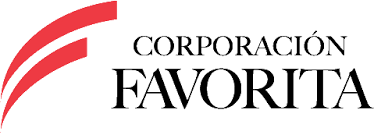

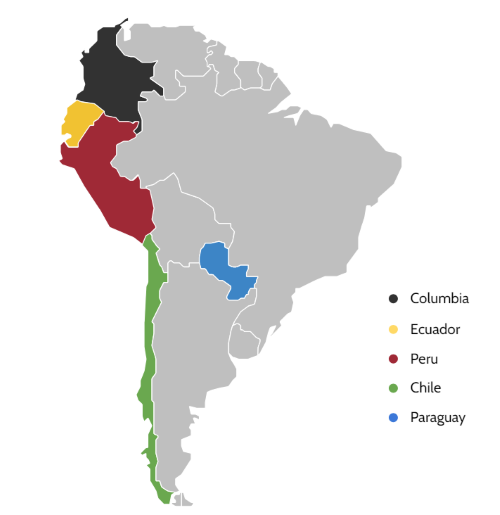

The time series spans from January 1, 2013, to August 31, 2017. Understanding the date range in the test data is crucial for devising a cross-validation strategy and developing new features.

## Data Preparation

In [82]:
transactions.head(10)

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520
231,2013-01-07,1,1807
277,2013-01-08,1,1869
323,2013-01-09,1,1910
369,2013-01-10,1,1679
415,2013-01-11,1,1813


In [83]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,1,2013-01-01,1,BABY CARE,0.000000,0
2,2,2013-01-01,1,BEAUTY,0.000000,0
3,3,2013-01-01,1,BEVERAGES,0.000000,0
4,4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8


- categorize the data in train.csv according to their family, and arrange date from earliest to latest

- <strong>Transactions data</strong> refer to the quantity of invoices generated within a day. 
The transactions data shows a strong correlation with the sales data in the training dataset, providing insight into the sales patterns of the stores.<br><br>


- <strong>Store sales data</strong> represent the number of sales generated from a specific product category within a particular store on a specified date. It is important to note that fractional values are possible due to the products being sold in fractional units (such as 1.5 kg of cheese, rather than whole units like 1 bag of chips).

## Exploratory Data Analysis 

<Axes: >

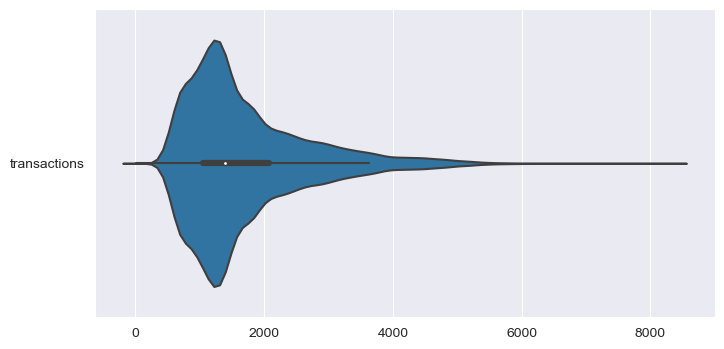

In [84]:
transac = pd.DataFrame(transactions['transactions']) #number of transactions
f = plt.figure(figsize=(8, 4))
sb.violinplot(data = transac, orient = "h")

We use a violin plot to visualize the distribution of the monthly average number of transactions from all stores from 2013 to 2017. We can see the monthly average number of transactions for a store is around 1694 transactions.

In [85]:
transac.describe()

,transactions
count,83488.000000
mean,1694.602158
std,963.286644
min,5.000000
25%,1046.000000
50%,1393.000000
75%,2079.000000
max,8359.000000


### Find number of monthly average transactions for each year
- Add the number of transactions together for a month and get the average
- Add a "month" column to the dataframe

In [86]:
a = transactions.set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year

#add a "month" column to the dataframe
sr = pd.to_datetime(a['date']) 
result = sr.dt.month_name()#locale = 'English') 
a2 = a.assign(month=result)

In [87]:
#monthly average transactions for 2013
a2013 = a2.loc[a['year'] == 2013]
a2013

,date,transactions,year,month
0,2013-01-31,1657.898624,2013,January
1,2013-02-28,1684.483696,2013,February
2,2013-03-31,1724.181627,2013,March
3,2013-04-30,1699.206522,2013,April
4,2013-05-31,1702.874396,2013,May
5,2013-06-30,1701.426743,2013,June
6,2013-07-31,1675.012552,2013,July
7,2013-08-31,1689.182567,2013,August
8,2013-09-30,1688.270922,2013,September
9,2013-10-31,1653.013040,2013,October


In [88]:
#monthly average transactions for each year
a2014 = a2.loc[a['year'] == 2014]
a2015 = a2.loc[a['year'] == 2015]
a2016 = a2.loc[a['year'] == 2016]
a2017 = a2.loc[a['year'] == 2017]

>It seems that there is a pattern with the number of transactions increasing at the end of the year in  December.

<Axes: xlabel='month', ylabel='transactions'>

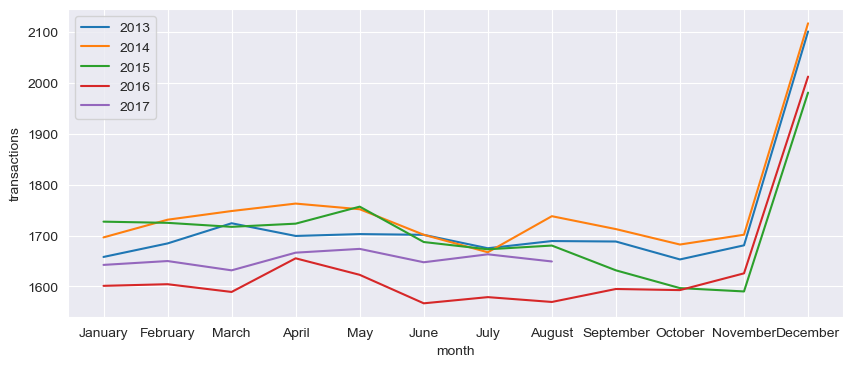

In [89]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))
    
sb.lineplot(data=a2013, x="month", y="transactions", ax=ax, label="2013")
sb.lineplot(data=a2014, x="month", y="transactions", ax=ax, label="2014")
sb.lineplot(data=a2015, x="month", y="transactions", ax=ax, label="2015")
sb.lineplot(data=a2016, x="month", y="transactions", ax=ax, label="2016")
sb.lineplot(data=a2017, x="month", y="transactions", ax=ax, label="2017")

### Which day of the week has the most transactions on average?
The days of the week play a significant role in shopping behavior, revealing consistent patterns over the years 2013 to 2017.

In [90]:
a = transactions.copy()
a

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520
...,...,...,...
83271,2017-08-11,54,768
83325,2017-08-12,54,903
83379,2017-08-13,54,1054
83433,2017-08-14,54,818


- organize the data by the year 
- find out which day it is on that specific date
- get the average number of transactions for the day of week

In [91]:
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()
a.head(10)

,year,dayofweek,transactions
0,2013,1,1681.433113
1,2013,2,1630.488650
2,2013,3,1627.738085
3,2013,4,1565.654148
4,2013,5,1650.341312
5,2013,6,2001.201816
6,2013,7,1891.635163
7,2014,1,1703.059519
8,2014,2,1659.322331
9,2014,3,1690.754886


In [92]:
a2013 = a.loc[a['year'] == 2013]
a2014 = a.loc[a['year'] == 2014]
a2015 = a.loc[a['year'] == 2015]
a2016 = a.loc[a['year'] == 2016]
a2017 = a.loc[a['year'] == 2017]

We can see here that stores experience higher transaction volumes on weekends, with Saturday emerging as the busiest shopping day throughout this period.
- This means most people are likely to go shopping on Saturday compared to other days of the week

<Axes: xlabel='dayofweek', ylabel='transactions'>

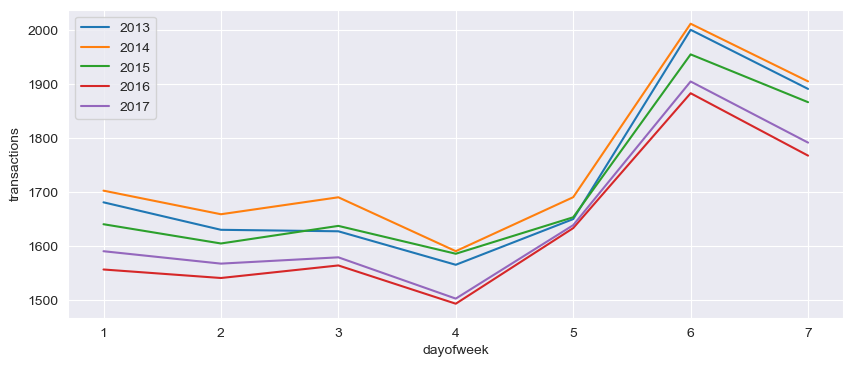

In [93]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))
    
sb.lineplot(data=a2013, x="dayofweek", y="transactions", ax=ax, label="2013")
sb.lineplot(data=a2014, x="dayofweek", y="transactions", ax=ax, label="2014")
sb.lineplot(data=a2015, x="dayofweek", y="transactions", ax=ax, label="2015")
sb.lineplot(data=a2016, x="dayofweek", y="transactions", ax=ax, label="2016")
sb.lineplot(data=a2017, x="dayofweek", y="transactions", ax=ax, label="2017")

### Which product category sells the most items? 

In [94]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,1,2013-01-01,1,BABY CARE,0.000000,0
2,2,2013-01-01,1,BEAUTY,0.000000,0
3,3,2013-01-01,1,BEVERAGES,0.000000,0
4,4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8


- Calculate the average daily number of sales for a specific category   
- The graph shows us GROCERY I, BEVERAGES, and PRODUCE are the top 3 selling categories among the grocery stores.

<Axes: xlabel='sales', ylabel='family'>

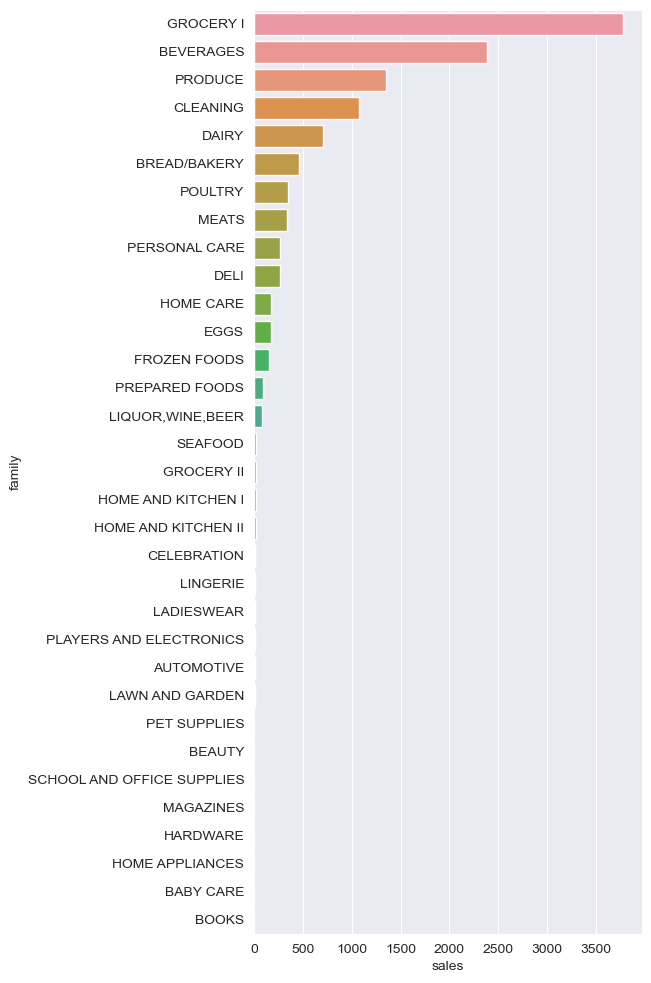

In [95]:
a = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
a

fig, ax = plt.subplots(figsize=(5, 12))
sb.barplot(x=a.sales, y=a.family, orient='h')

### Is there a correlation between sales and transactions?
- merge sales and transactions data by date
- High correlation between total sales and transactions

In [96]:
temp = pd.merge(train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")
temp

,date,store_nbr,sales,transactions
0,2013-01-01,1,0.000000,NaN
1,2013-01-01,2,0.000000,NaN
2,2013-01-01,3,0.000000,NaN
3,2013-01-01,4,0.000000,NaN
4,2013-01-01,5,0.000000,NaN
...,...,...,...,...
90931,2017-08-15,50,16879.121094,2804.0
90932,2017-08-15,51,20154.558594,1573.0
90933,2017-08-15,52,18600.044922,2255.0
90934,2017-08-15,53,8208.189453,932.0


<Axes: xlabel='transactions', ylabel='sales'>

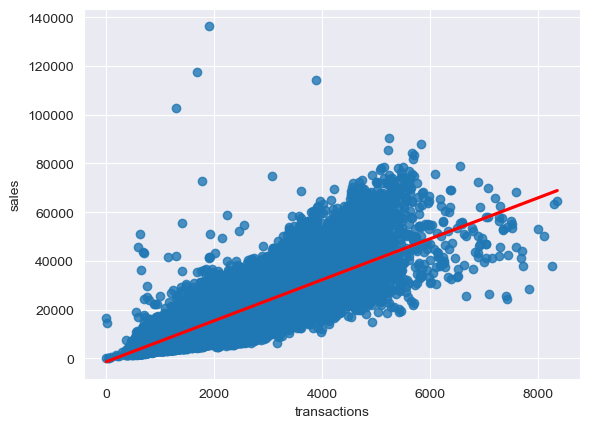

In [97]:
sb.regplot(temp, x = "transactions", y = "sales", line_kws=dict(color="r"))

### What is a Time Series?

The basic object of forecasting is the time series, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

In [98]:
def grouped(df, key, freq, col):
    #group data with certain frequency
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [99]:
df_grouped_train_w = grouped(train, 'date', 'W', 'sales')
df_grouped_train_w

,date,mean
0,2013-01-06,206.843475
1,2013-01-13,190.285217
2,2013-01-20,189.835464
3,2013-01-27,182.152054
4,2013-02-03,198.564270
...,...,...
237,2017-07-23,460.504639
238,2017-07-30,474.732391
239,2017-08-06,513.884338
240,2017-08-13,431.730164


In [100]:
df_grouped_train_w = df_grouped_train_w.set_index("date")
df = df_grouped_train_w.copy()
df['Time'] = np.arange(len(df_grouped_train_w.index))
df.head()

,mean,Time
date,,
2013-01-06,206.843475,0
2013-01-13,190.285217,1
2013-01-20,189.835464,2
2013-01-27,182.152054,3
2013-02-03,198.564270,4


In [101]:

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'mean']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

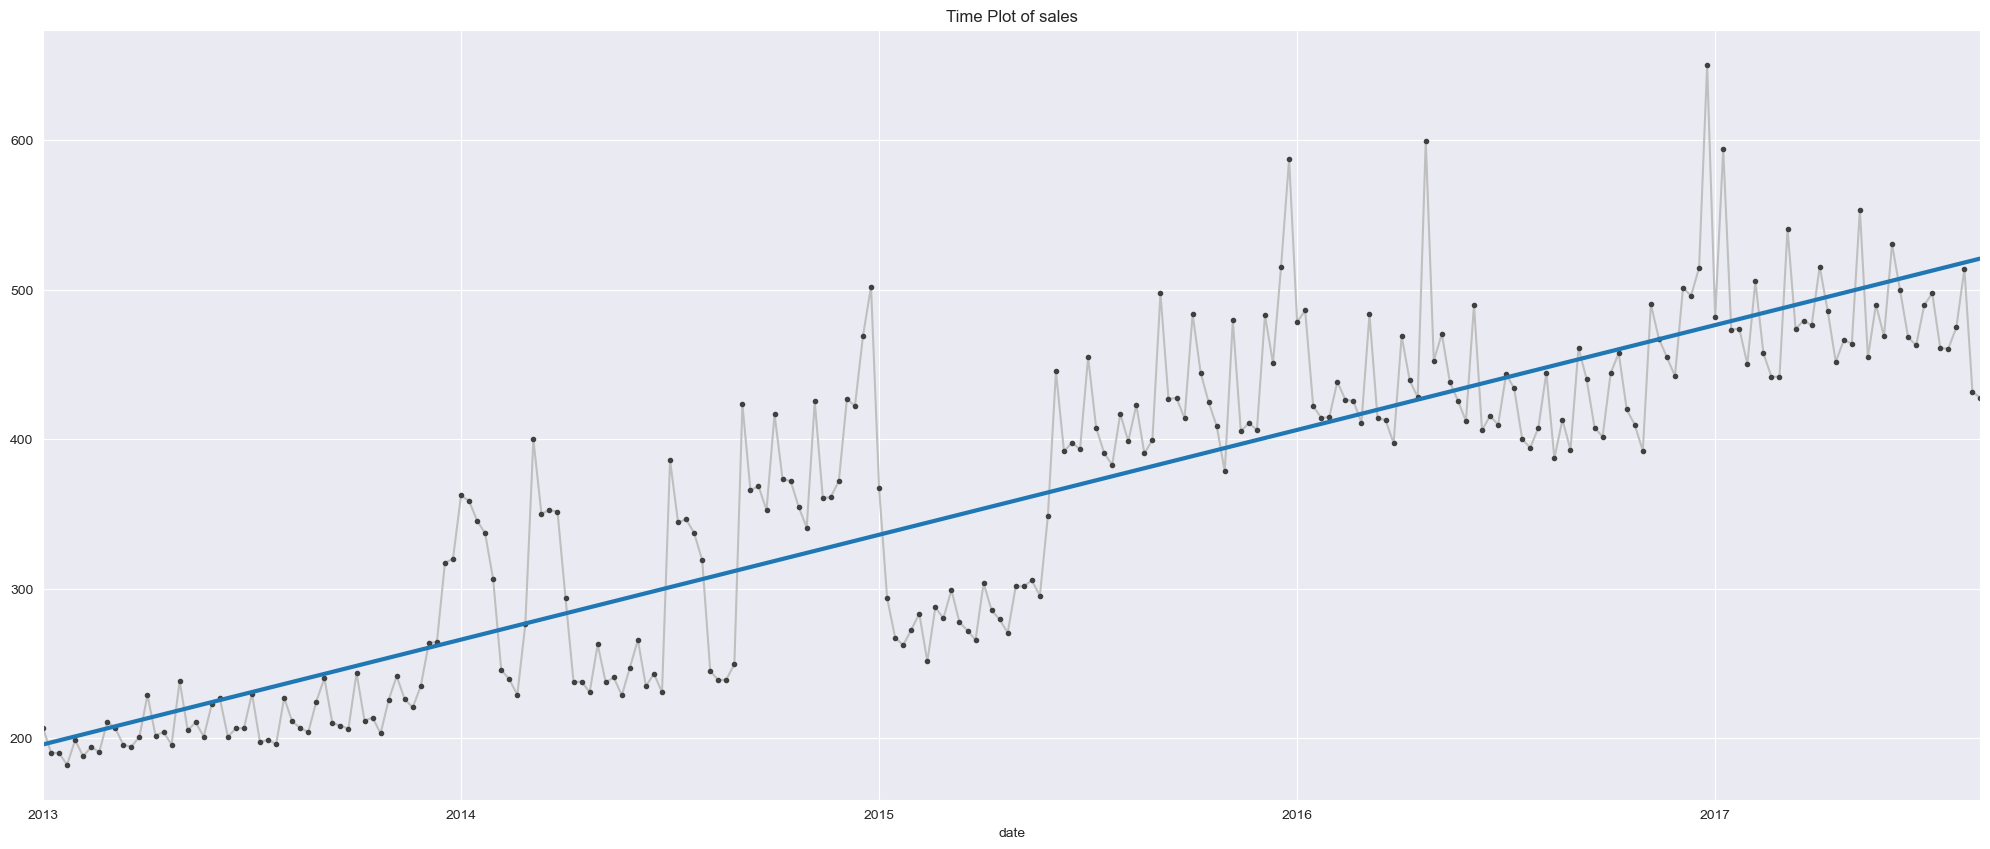

In [102]:
fig, axes = plt.subplots(figsize=(25,10))
ax = y.plot(color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of sales');

In [103]:
df_grouped = grouped(train, 'date', 'W', 'sales')
df_grouped

,date,mean
0,2013-01-06,206.843475
1,2013-01-13,190.285217
2,2013-01-20,189.835464
3,2013-01-27,182.152054
4,2013-02-03,198.564270
...,...,...
237,2017-07-23,460.504639
238,2017-07-30,474.732391
239,2017-08-06,513.884338
240,2017-08-13,431.730164


### What is Trend?
The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

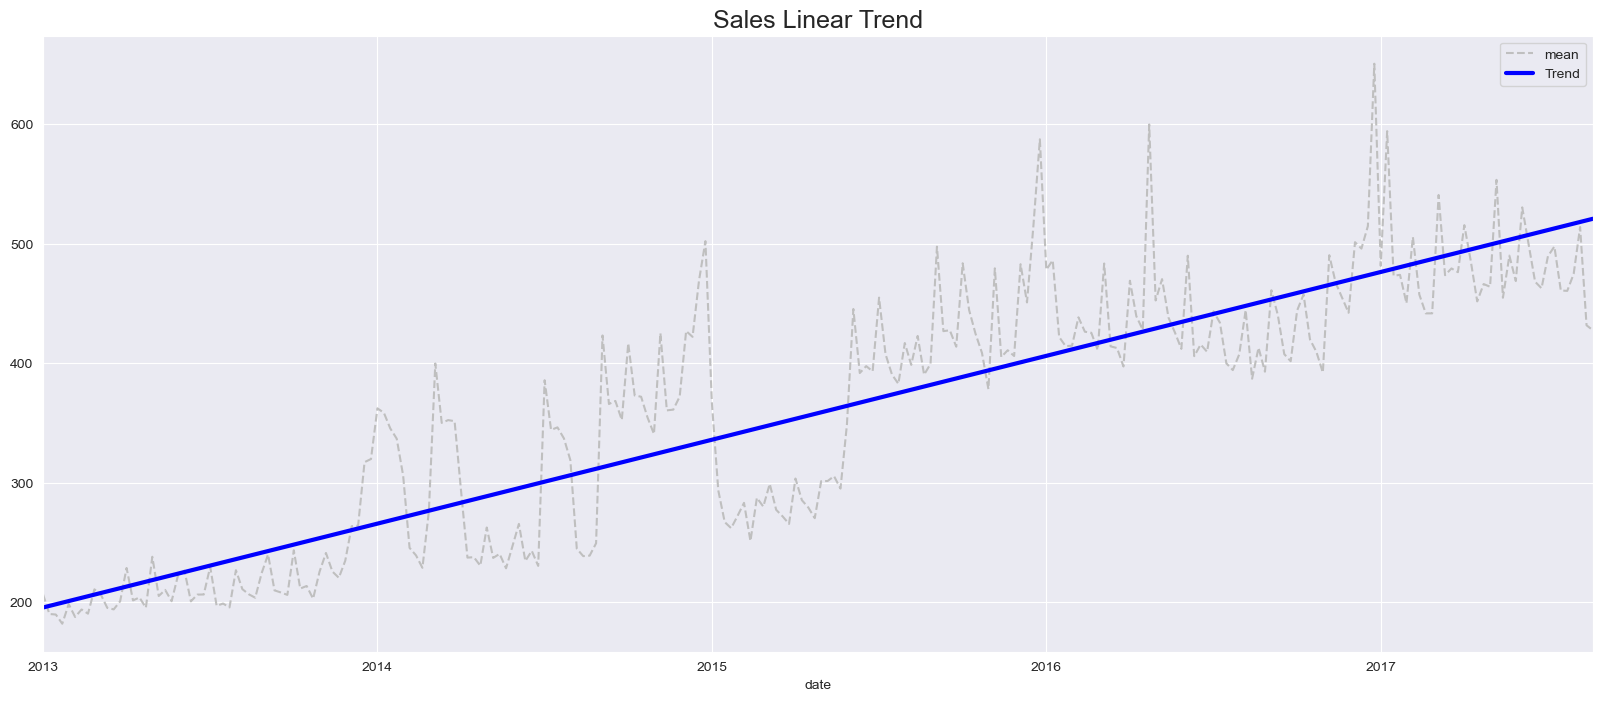

In [104]:
fig, axes = plt.subplots(figsize=(20,8))

df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d") 
dp = DeterministicProcess(index=df_grouped['date'], constant=True, order=1, drop=True)
dp.index.freq = 'W' # manually set the frequency of the index
# 'in_sample' creates features for the dates given in the `index` argument
X1 = dp.in_sample()
y1 = df_grouped["mean"]  # the target
y1.index = X1.index
# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X1, y1)
y1_pred = pd.Series(model.predict(X1), index=X1.index)
ax1 = y1.plot(linestyle='dashed', label="mean", color="0.75")
ax1 = y1_pred.plot(linewidth=3, label="Trend", color='b')
ax1.set_title("Sales Linear Trend", fontsize=18)  
_ = ax1.legend()

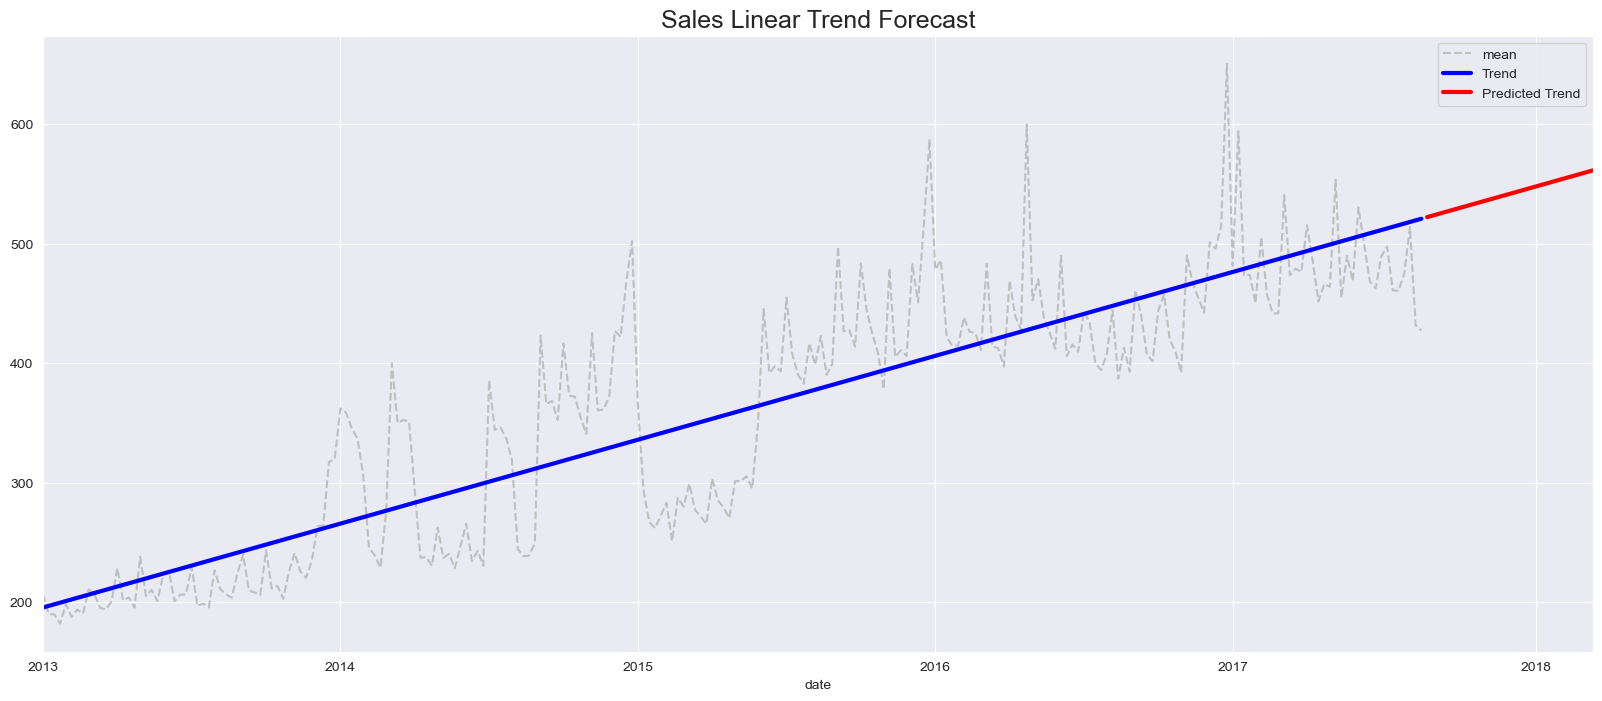

In [105]:
fig, axes = plt.subplots(figsize=(20,8))

steps = 30 
X2 = dp.out_of_sample(steps=30)
y2_fore = pd.Series(model.predict(X2), index=X2.index)
y2_fore.head()
ax2 = y1.plot(linestyle='dashed', label="mean", color="0.75")
ax2 = y1_pred.plot(linewidth=3, label="Trend", color='b')
ax2 = y2_fore.plot(linewidth=3, label="Predicted Trend", color='r')
ax2.set_title("Sales Linear Trend Forecast", fontsize=18)  
_ = ax2.legend()

Besides acting as a baseline or starting point for more sophisticated models, this trend model can be useful for a number of reasons as it shows us a rough forecast of the sales.

In [106]:
print(df.columns)

Index(['mean', 'Time'], dtype='object')


### Seasonality
Time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times. Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns. We will do this using 4 different ML models: Linear Regression, polynomial regression, Holt-Winters model and SARIMA

In [109]:
def predict_seasonality(df, key, freq, col, ax1, title1, model_type='linear'):
    # Check if the key exists in the dataframe
    if key not in df.columns:
        raise KeyError(f"Key '{key}' is not found in the dataframe columns.")

    # Convert key column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df[key]):
        df[key] = pd.to_datetime(df[key], errors='coerce')
        if df[key].isnull().any():
            raise ValueError(f"Some entries in the '{key}' column could not be converted to datetime.")

    # Group by the specified key and calculate the mean of the column
    df_grouped = df.groupby(pd.Grouper(key=key, freq=freq))[col].mean()
    df_grouped.index.name = 'date'
    df_grouped = df_grouped.reset_index()
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format="%Y-%m-%d")
    df_grouped.set_index('date', inplace=True)
    df_grouped.index.freq = freq  # Manually set the frequency of the index

    y_pred = None
    y_fore = None
    
    
    if model_type == 'linear':
        fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality
        dp = DeterministicProcess(index=df_grouped.index, 
                                  constant=True, 
                                  order=1, 
                                  seasonal=True, 
                                  additional_terms=[fourier], 
                                  drop=True)
        X1 = dp.in_sample()
        y1 = df_grouped[col]  # the target
        y1.index = X1.index
        model = LinearRegression(fit_intercept=False)
        model.fit(X1, y1)
        y_pred = pd.Series(model.predict(X1), index=X1.index)
        X_fore = dp.out_of_sample(steps=90)
        y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
        
        ax1 = y_pred.plot(linestyle='dashed', style='.', label="Init Mean Values", color="0.4", ax=ax1)
        ax1 = y_pred.plot(linewidth=3, label="Seasonal Fit", color='b', ax=ax1)
        ax1 = y_fore.plot(linewidth=3, label="Seasonal Forecast", color='r', ax=ax1)
        ax1.set_title(title1, fontsize=18)  
        _ = ax1.legend()

    elif model_type == 'polynomial':
        
        poly_degree = 3  # You can adjust this to see different effects
        scaler = MinMaxScaler()
        poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
        # Create and scale polynomial features
        X = np.array(range(len(df_grouped))).reshape(-1, 1)
        X_scaled = scaler.fit_transform(X)
        X_poly = poly.fit_transform(X_scaled)
        y = df_grouped[col]
        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = pd.Series(model.predict(X_poly), index=df_grouped.index)
        # Forecast
        X_fore = np.array(range(len(df_grouped), len(df_grouped) + 90)).reshape(-1, 1)
        X_fore_scaled = scaler.transform(X_fore)
        X_fore_poly = poly.transform(X_fore_scaled)
        y_fore = pd.Series(model.predict(X_fore_poly), index=pd.date_range(df_grouped.index[-1], periods=90, freq=freq))

        

    elif model_type == 'holt_winters':
        model = ExponentialSmoothing(df_grouped[col], trend='add', seasonal='add', seasonal_periods=52)
        model_fit = model.fit()
        y_pred = model_fit.fittedvalues
        y_fore = model_fit.forecast(90)

    elif model_type == 'sarima':
        order = (1, 1, 1)
        seasonal_order = (1, 1, 1, 52)
        model = SARIMAX(df_grouped[col], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        y_pred = model_fit.fittedvalues
        y_fore = model_fit.forecast(90)
        
    
    ax1 = df_grouped[col].plot(linestyle='dashed', style='.', label="Observed Values", color="0.4", ax=ax1)
    ax1 = y_pred.plot(linewidth=3, label=f"{model_type.capitalize()} Fit", color='b', ax=ax1)
    ax1 = y_fore.plot(linewidth=3, label=f"{model_type.capitalize()} Forecast", color='r', ax=ax1)
    ax1.set_title(title1, fontsize=18)  
    _ = ax1.legend()
    
    mae = mean_absolute_error(df_grouped[col], y_pred)
    mse = mean_squared_error(df_grouped[col], y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((df_grouped[col] - y_pred) / df_grouped[col])) * 100
    r2 = r2_score(df_grouped[col], y_pred)
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")
    print(f"R-squared: {r2}")


## Linear Regression

MAE: 32.30948441973001
MSE: 1536.6701359658282
RMSE: 39.200384385434646
MAPE: 9.906424300391423
R-squared: 0.8680411858321604


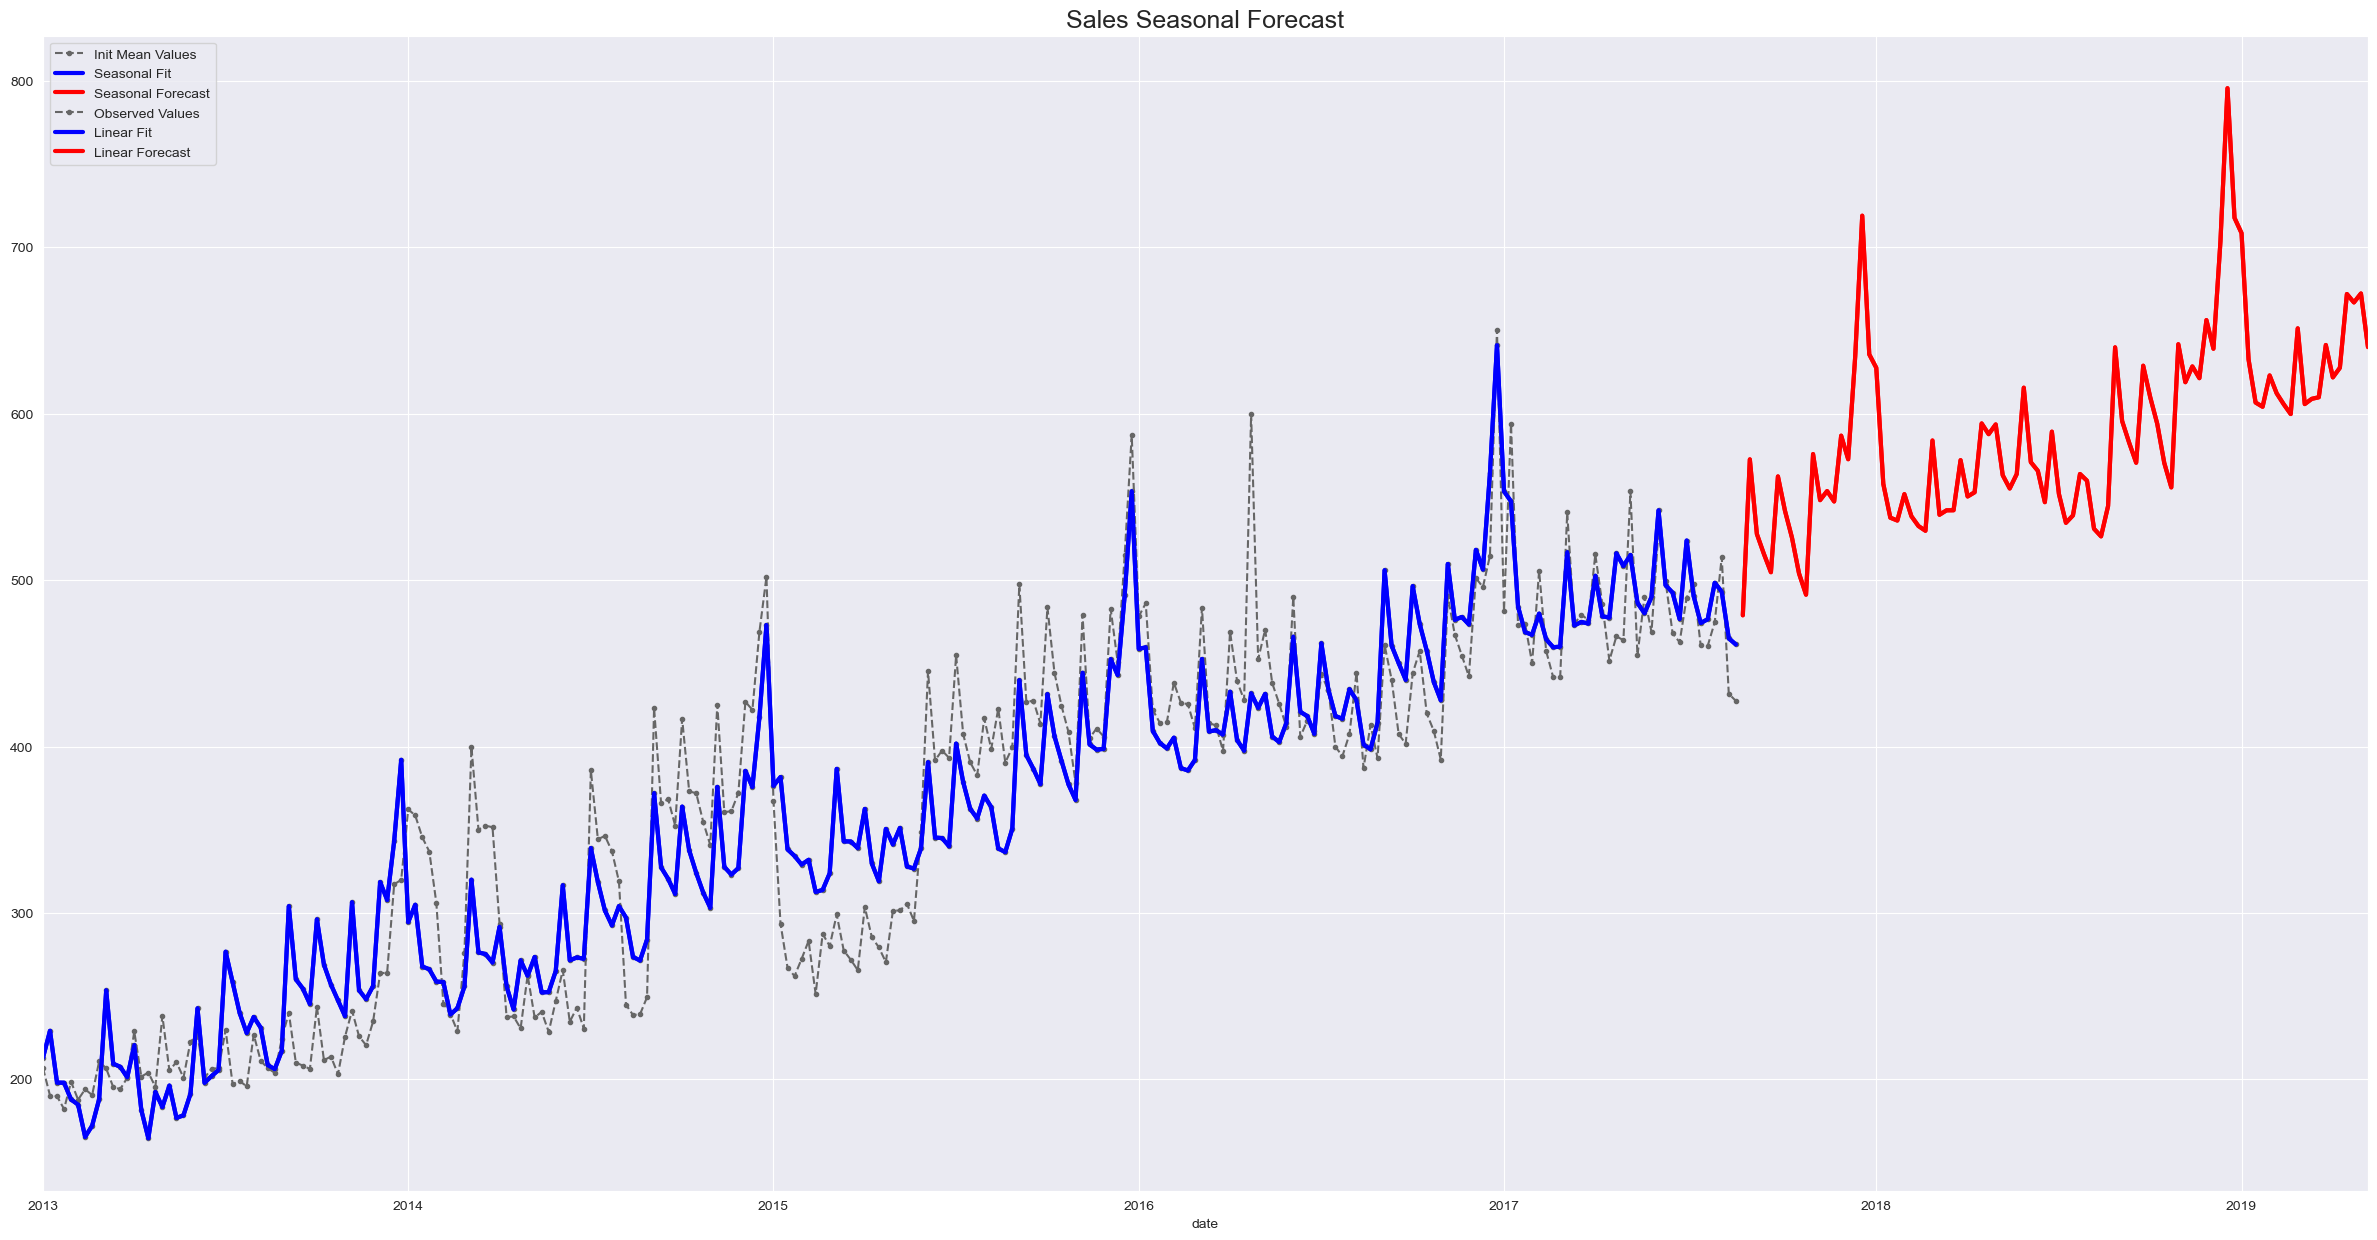

In [110]:
fig, axes = plt.subplots(figsize=(30,15))
predict_seasonality(train, 'date', 'W', 'sales', axes, "Sales Seasonal Forecast", model_type='linear')
plt.show()

### Polynomial Regression

MAE: 38.148837379235665
MSE: 2595.1583820909163
RMSE: 50.942697043746286
MAPE: 11.11231394362672
R-squared: 0.7771453907619496


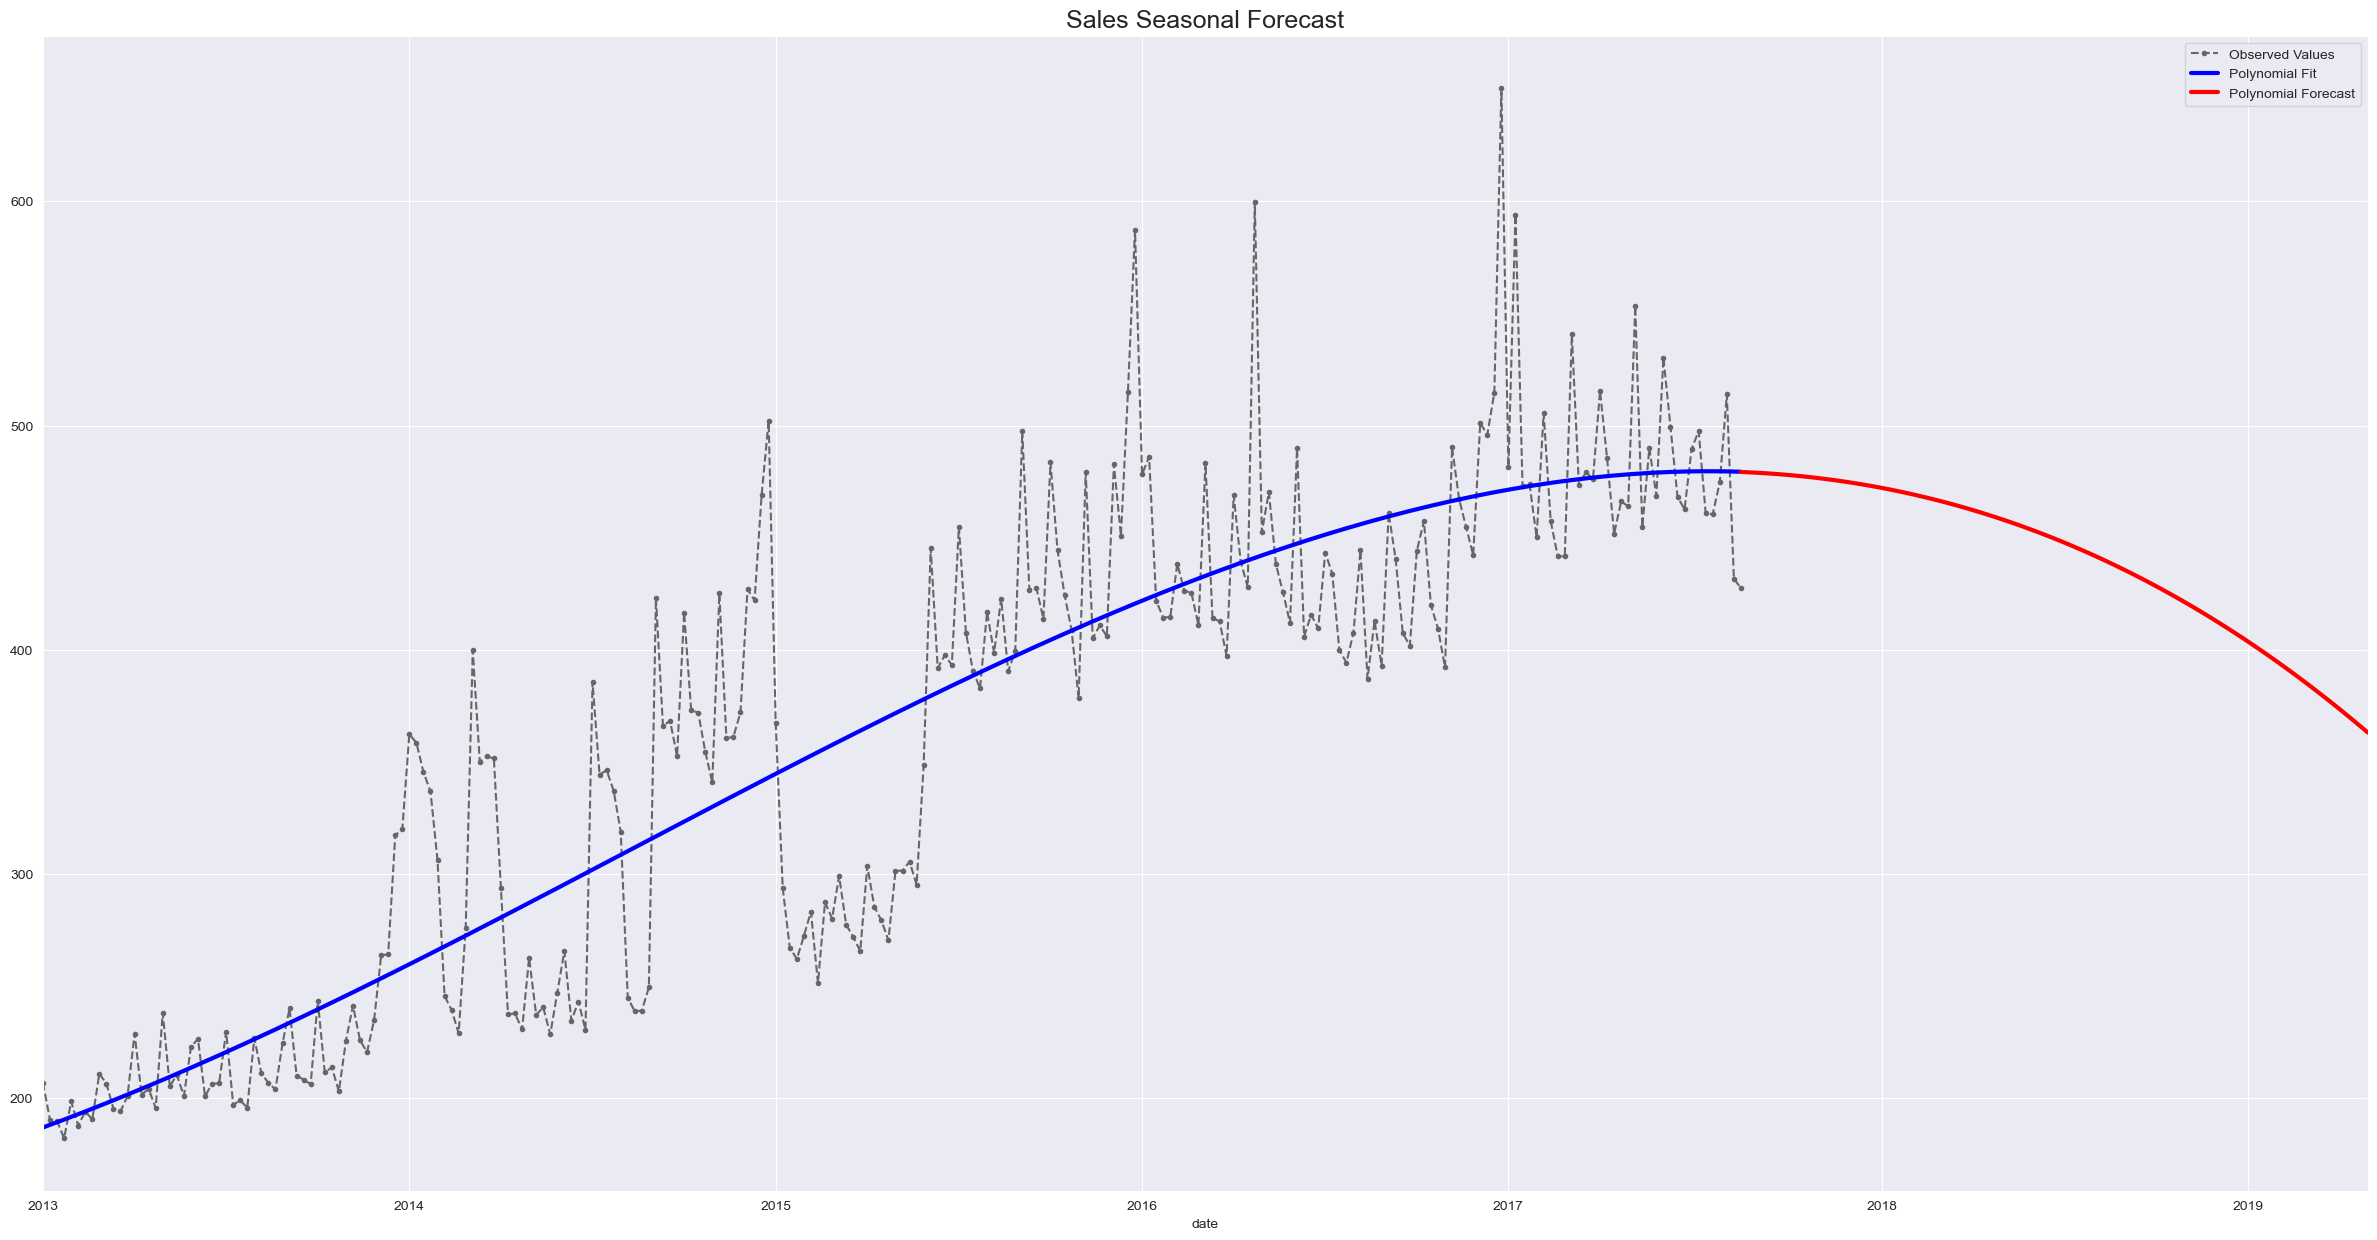

In [111]:
fig, axes = plt.subplots(figsize=(30,15))
predict_seasonality(train, 'date', 'W', 'sales', axes, "Sales Seasonal Forecast", model_type='polynomial')
plt.show()

### Holt Winters

MAE: 20.77237061691071
MSE: 893.9169047900451
RMSE: 29.898443183384067
MAPE: 6.203625468783263
R-squared: 0.9232364760921579


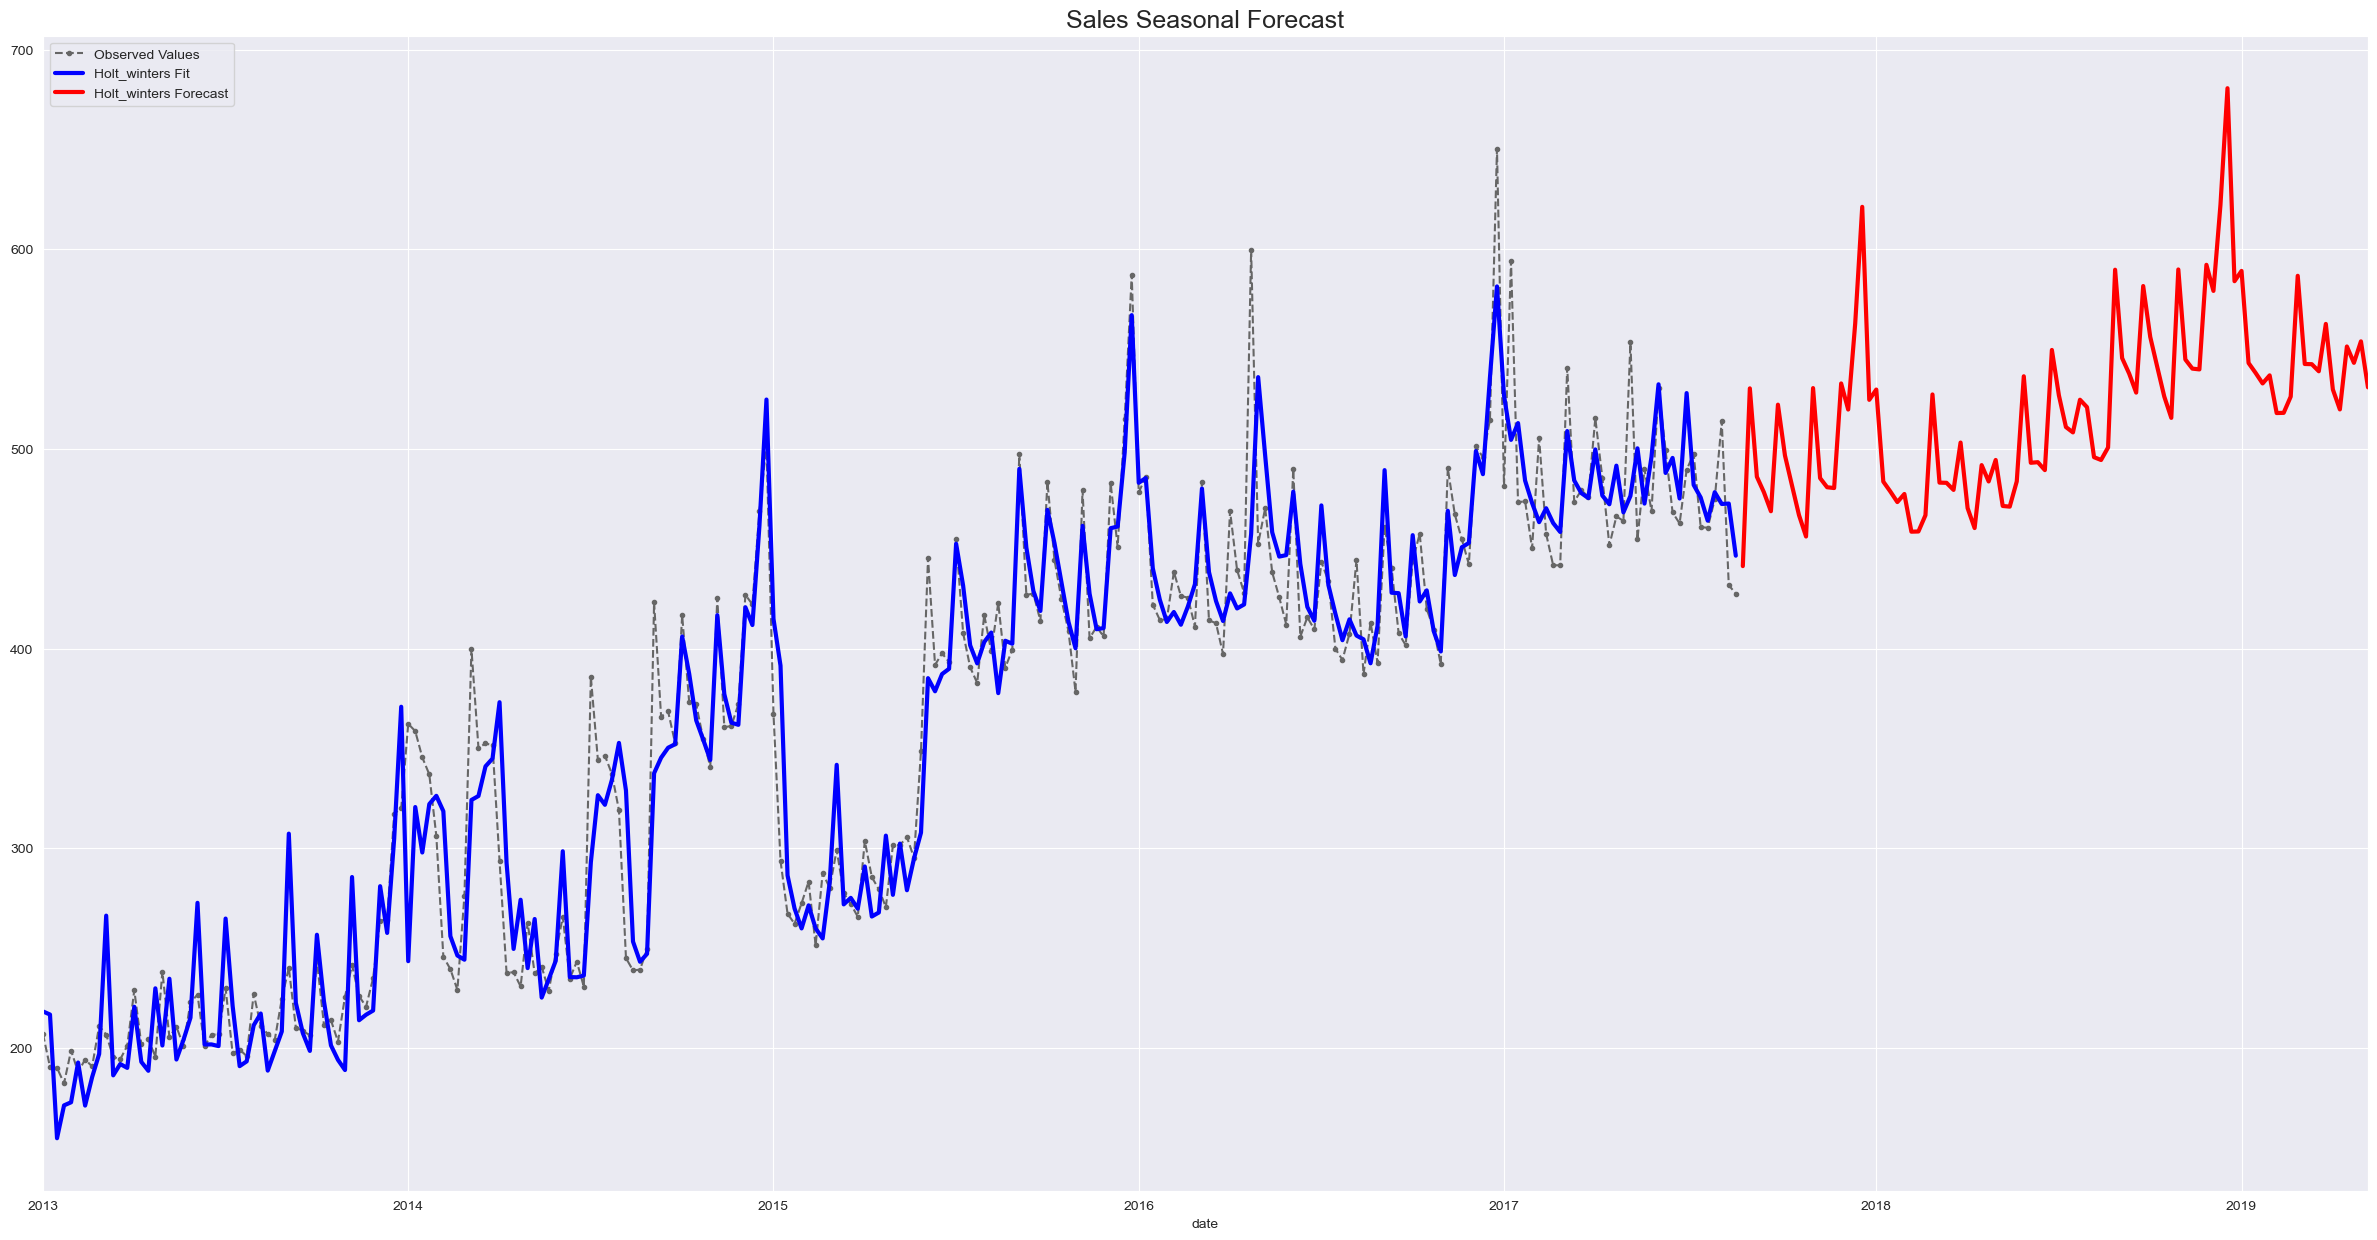

In [112]:
fig, axes = plt.subplots(figsize=(30,15))
predict_seasonality(train, 'date', 'W', 'sales', axes, "Sales Seasonal Forecast", model_type='holt_winters')
plt.show()

### SARIMA (Seasonal AutoRegressive Integrated Moving Average)

/Users/maxwong/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


MAE: 25.872901906933805
MSE: 1604.90310385599
RMSE: 40.06124191604636
MAPE: 7.397494831242563
R-squared: 0.8621818011020219


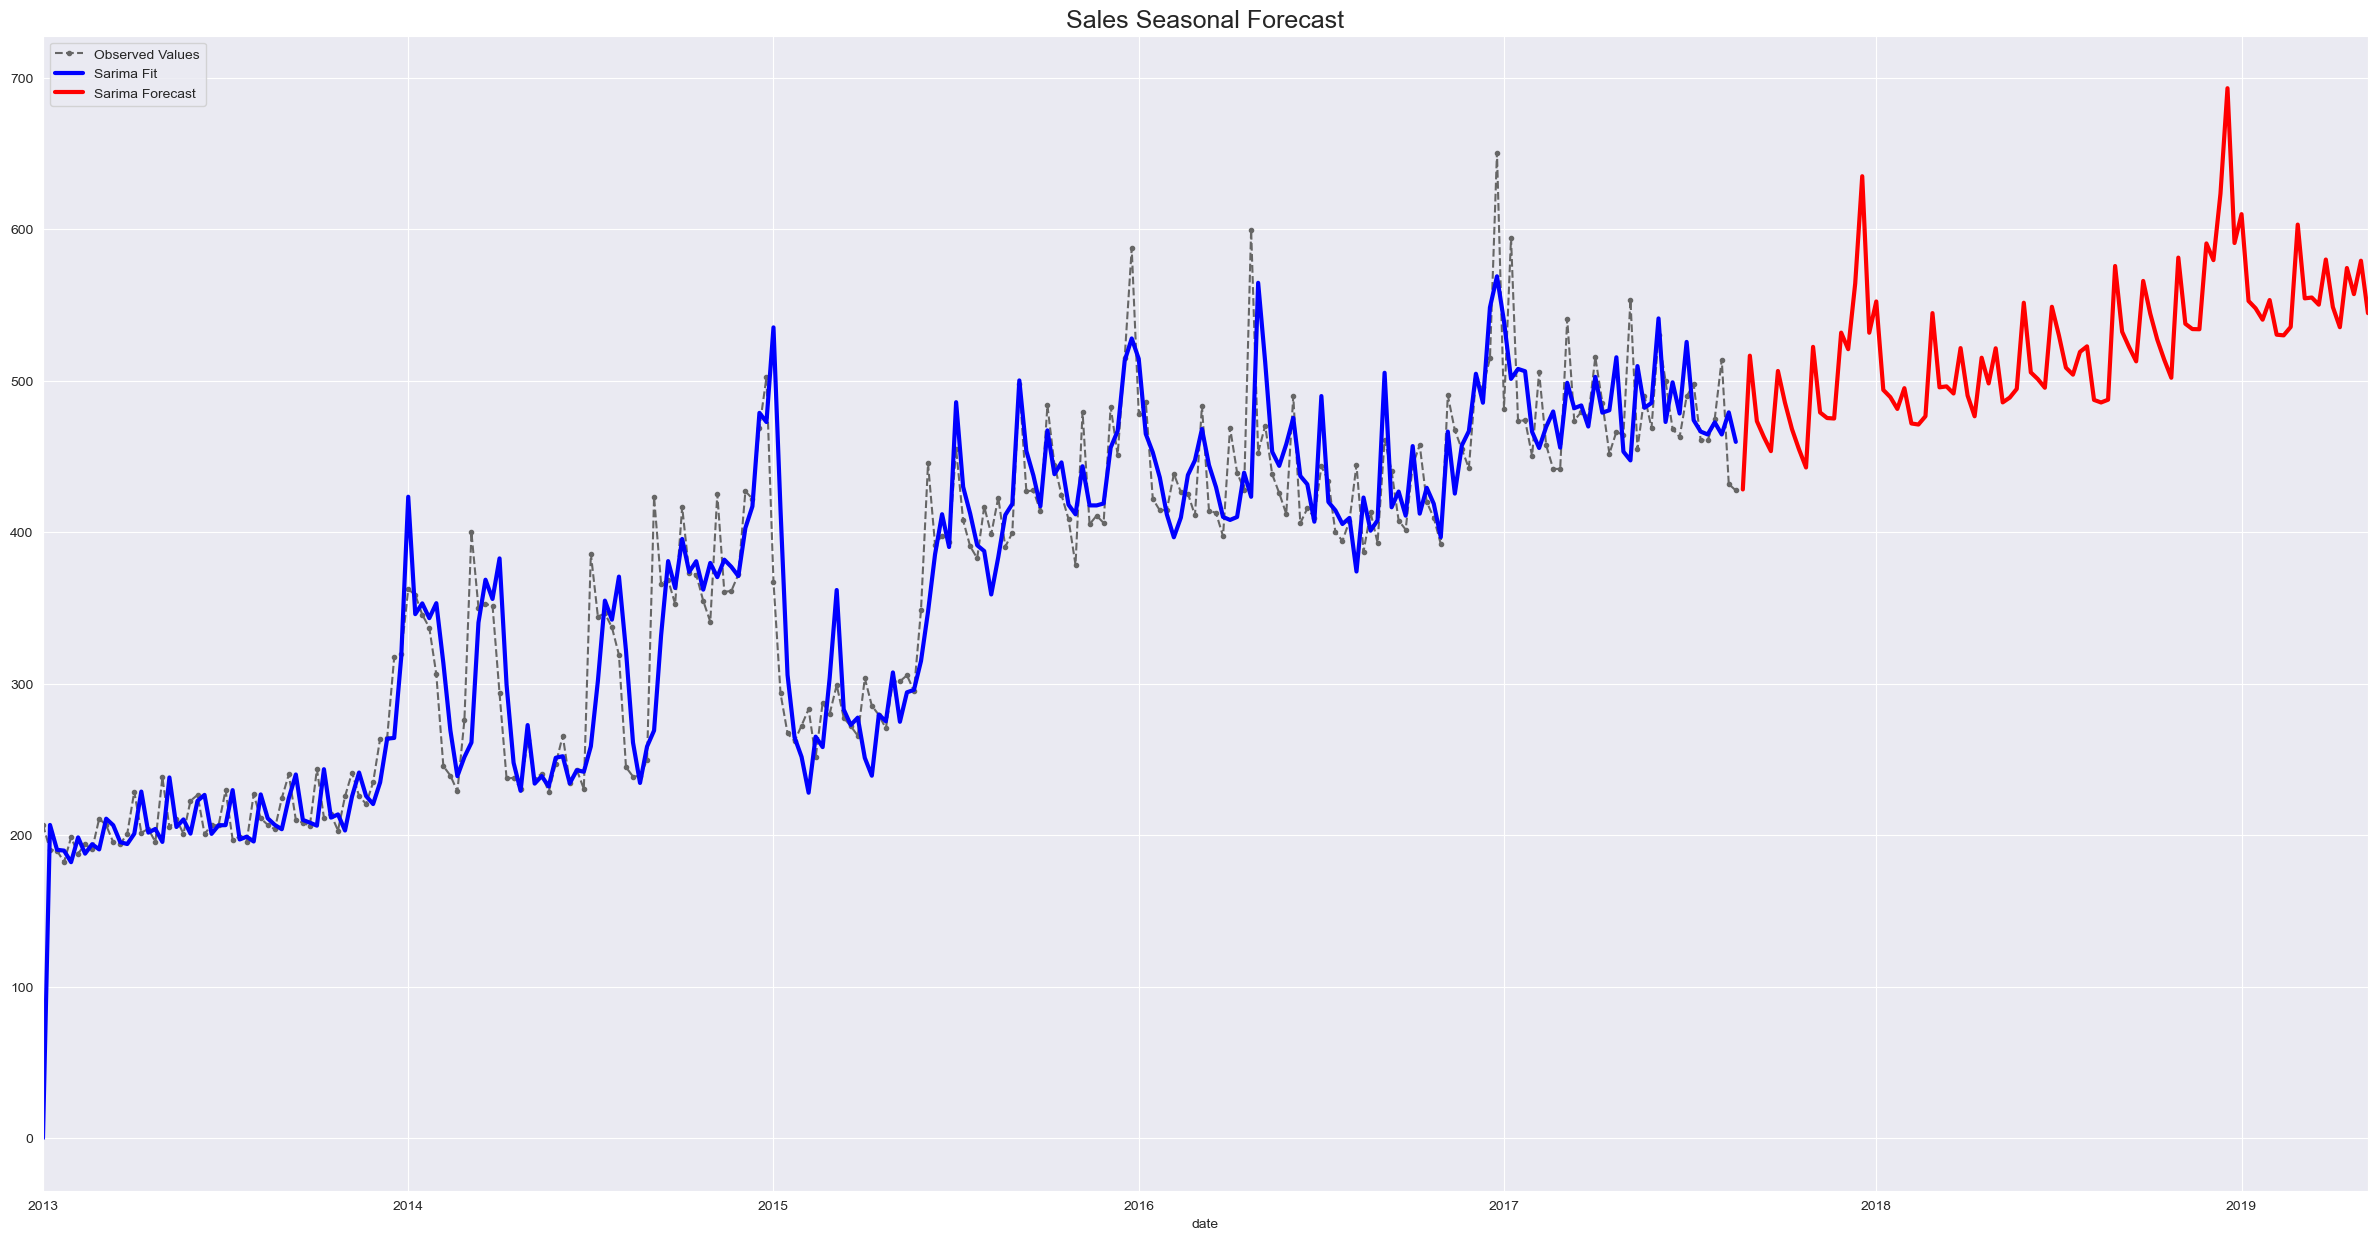

In [113]:
fig, axes = plt.subplots(figsize=(30,15))
predict_seasonality(train, 'date', 'W', 'sales', axes, "Sales Seasonal Forecast", model_type='sarima')
plt.show()